# Cannonical Correlation Analysis of ERN and Pe results

### Imports

In [51]:
import os
import re
import glob
import os
import ast
import os.path as op
from collections import defaultdict
from copy import deepcopy
import copy

import pickle
from time import time
# import pywt
import mne
import scipy
import numpy as np
# import plotly.graph_objects as go
# import plotly.express as px
import pandas as pd
# import cesium.featurize
# from plotly.subplots import make_subplots
# from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, FloatSlider, interact
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, BaseEstimator

import sys

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVR
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from rumination_experiment_transformers_averaged_CDS import *

from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load pickled ERN and Pe results

In [3]:
results_ern = pd.read_pickle("../public_data/results/models_pickles/ern_results_with_external-p.pkl")
results_pe = pd.read_pickle("../public_data/results/models_pickles/pe_results_with_external-p.pkl")

### Extract significant relationships

In [4]:
significant_results = results_ern[(results_ern['external_score'] > 0.0) & (results_ern['external_p-value'] < 0.07)]
significant_results

,data_set,pipeline_name,model,parameters,mean_cv_r2,std_cv_r2,mean_cv_mae,std_cv_mae,mean_cv_mse,std_cv_mse,cv_results,mean_train_r2,mean_train_mae,mean_train_mse,p-value,best_estimator,pre_processed_pipeline,scale,external_score,external_p-value
11,error_response,PCA_4_scale_15-Obsessional Beliefs - Overestim...,kr,"{'kr__alpha': 0.4281332398719396, 'kr__gamma':...",0.055361,0.089090,-0.979162,0.091681,-1.350341,0.246860,"{'mean_fit_time': [0.009642521540323893, 0.010...",0.196231,-0.904140,-1.148277,0.006993,"(FeatureUnion(n_jobs=10,\n transfo...","(PickChannels(channels_list=['Fpz', 'AFz', 'F1...",OT,0.059436,0.057942
12,error_response,PCA_3_scale_16-Rumination Full Scale,kr,"{'kr__alpha': 2.6366508987303556e-05, 'kr__gam...",0.068960,0.007099,-0.678509,0.046337,-0.744860,0.062957,"{'mean_fit_time': [0.011245250701904297, 0.014...",0.125565,-0.662442,-0.703920,0.003996,"(FeatureUnion(n_jobs=10,\n transfo...","(PickChannels(channels_list=['Fpz', 'AFz', 'Fz...",RRQ,0.070520,0.017982
14,error_response,PCA_6_scale_28-Intolerance of Uncertainty - In...,en,"{'en__alpha': 0.01832980710832434, 'en__l1_rat...",0.036322,0.026219,-0.471418,0.033994,-0.357236,0.021651,"{'mean_fit_time': [0.008257150650024414, 0.007...",0.124229,-0.455919,-0.328933,0.013986,"(FeatureUnion(n_jobs=10,\n transfo...","(PickChannels(channels_list=['Fpz', 'AFz', 'F1...",IUS-I,0.056105,0.069930


Extract pre-processing pipeline

In [5]:
pre_processing_pipeline_steps = significant_results['pre_processed_pipeline'].iloc[0].steps
pre_processing_pipeline_steps

[('channels_extraction',
  PickChannels(channels_list=['Fpz', 'AFz', 'F1', 'Fz', 'F2', 'FCz', 'C1', 'Cz',
                              'C2', 'CPz', 'P1', 'Pz', 'P2'])),
 ('average', Evoked()),
 ('extract_averaged_data', ExtractData()),
 ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
 ('spatial_filter', PCA(n_components=4, random_state=0)),
 ('spatial_filter_postprocessing',
  SpatialFilterPostprocessing(timepoints_count=181)),
 ('lowpass_filter', LowpassFilter()),
 ('binning', BinTransformer()),
 ('centering', CenteredSignalAfterBaseline3())]

In [6]:
post_pca_pipeline_steps = significant_results.best_estimator.iloc[0]['features'].transformer_list[0][1].steps
post_pca_pipeline_steps

[('ern_data_extraction', ErnTransformer()),
 ('ern_amplitude', ErnAmplitude2()),
 ('data_channel_swap', ChannelDataSwap()),
 ('postprocessing', PostprocessingTransformer()),
 ('scaler', StandardScaler())]

In [7]:
pipeline = Pipeline(pre_processing_pipeline_steps + post_pca_pipeline_steps)

Read data

In [8]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found")

Pickled file found. Loading pickled data...
Done


In [9]:
X_train_df = epochs_df

Create X set

In [15]:
X_train_eeg_features = pipeline.transform(X_train_df)
X_train_eeg_features.shape

(96, 13, 181)


(96, 4)

In [19]:
X_df = pd.DataFrame(X_train_eeg_features, columns=['PCA_1','PCA_2', 'PCA_3', 'PCA_4'])
X_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4
0,-0.581922,-0.168757,-1.135196,-0.166551
1,-0.412861,0.141481,0.665357,-0.214526
2,1.564176,-0.293272,3.371009,1.553244
3,-1.083597,-0.431022,-0.764672,-1.427828
4,-0.456852,0.272495,0.019829,-0.216957


Create y set

In [20]:
rumination = "16-Rumination Full Scale"
threat = "15-Obsessional Beliefs - Overestimation of threat"
IU_inhibitory = "28-Intolerance of Uncertainty - Inhibitory Anxiety"

scales = [
    rumination,
    threat,
    IU_inhibitory,
]

scales_dict = {
    "16-Rumination Full Scale": "RRQ",
    "15-Obsessional Beliefs - Overestimation of threat": "OT",
    "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I",
}

In [27]:
y_df = X_train_df[scales].rename(columns=scales_dict)
y_df.head()

,RRQ,OT,IUS-I
0,2.17,3.0,1.2
1,1.33,1.6,1.4
2,4.25,2.2,2.4
3,2.67,1.8,1.8
4,4.58,4.6,2.2


In [34]:
y_df = y_df.fillna(y_df.mean())

In [42]:
data_df = pd.concat([X_df, y_df], axis=1)
data_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,RRQ,OT,IUS-I
0,-0.581922,-0.168757,-1.135196,-0.166551,2.17,3.0,1.2
1,-0.412861,0.141481,0.665357,-0.214526,1.33,1.6,1.4
2,1.564176,-0.293272,3.371009,1.553244,4.25,2.2,2.4
3,-1.083597,-0.431022,-0.764672,-1.427828,2.67,1.8,1.8
4,-0.456852,0.272495,0.019829,-0.216957,4.58,4.6,2.2


### CCA

In [36]:
# Instantiate the Canonical Correlation Analysis with 2 components
cca = CCA(n_components=2)

# Fit the model
cca.fit(X_df, y_df)

CCA()

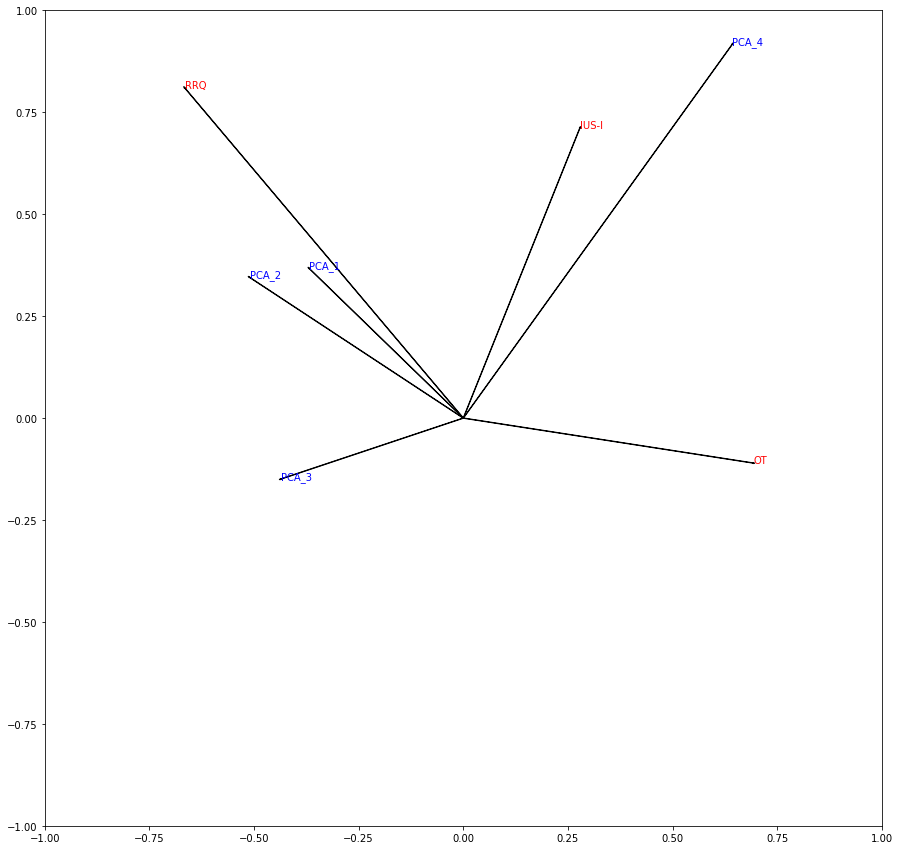

In [50]:
# Obtain the rotation matrices
xrot = cca.x_rotations_ 
yrot = cca.y_rotations_ 

# Put them together in a numpy matrix
xyrot = np.vstack((xrot,yrot))

nvariables = xyrot.shape[0]

plt.figure(figsize=(15, 15))
plt.xlim((-1,1))
plt.ylim((-1,1))

# Plot an arrow and a text label for each variable
for var_i in range(nvariables):
    x = xyrot[var_i,0]
    y = xyrot[var_i,1]

    plt.arrow(0,0,x,y)
    plt.text(x,y,data_df.columns[var_i], color='red' if var_i >= 4 else 'blue')

plt.show()

## Compute ERN and Pe components scores

### 1. Extract data pre-processing pipeliens for ERn and Pe

#### Extract post-PCA pipeline for ERN

In [5]:
last_steps_pipeline_ern = results_ern.best_estimator.iloc[0]['features'].transformer_list[0][1][:-1]
last_steps_pipeline_ern

Pipeline(steps=[('ern_data_extraction', ErnTransformer()),
                ('ern_amplitude', ErnAmplitude2()),
                ('data_channel_swap', ChannelDataSwap()),
                ('postprocessing', PostprocessingTransformer())])

#### Extract post-PCA pipeline for Pe

In [5]:
last_steps_pipeline_pe = results_pe.best_estimator.iloc[0]['features'].transformer_list[0][1][:-1]
last_steps_pipeline_pe

Pipeline(steps=[('pe_data_extraction', PeTransformer(stop_pe_bin=9)),
                ('pe_amplitude', PeAmplitude2()),
                ('data_channel_swap', ChannelDataSwap()),
                ('postprocessing', PostprocessingTransformer())])

#### Extract PCA-pipeline for both ERN ROIs

In [6]:
# ROI 1
roi_1_pipeline = results_ern.pre_processed_pipeline.iloc[9]
roi_1 = roi_1_pipeline['channels_extraction'].channels_list

print(roi_1_pipeline)
print(roi_1)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'Fz', 'FCz', 'Cz',
                                             'CPz', 'P1', 'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'Fz', 'FCz', 'Cz', 'CPz', 'P1', 'Pz', 'P2']


In [7]:
# ROI 2
roi_2_pipeline = results_ern.pre_processed_pipeline.iloc[15]
roi_2 = roi_2_pipeline['channels_extraction'].channels_list

print(roi_2_pipeline)
print(roi_2)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'F1', 'Fz', 'F2',
                                             'FCz', 'C1', 'Cz', 'C2', 'CPz',
                                             'P1', 'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'F1', 'Fz', 'F2', 'FCz', 'C1', 'Cz', 'C2', 'CPz', 'P1', 'Pz', 'P2']


#### Extract PCA-pipeline for both Pe ROIs

In [8]:
# ROI 3
roi_3_pipeline = results_pe.pre_processed_pipeline.iloc[13]
roi_3 = roi_3_pipeline['channels_extraction'].channels_list

print(roi_3_pipeline)
print(roi_3)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'Fz', 'FCz', 'C1',
                                             'Cz', 'C2', 'CPz', 'P1', 'Pz',
                                             'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()), ('baseline', ErnBaselined()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'Fz', 'FCz', 'C1', 'Cz', 'C2', 'CPz', 'P1', 'Pz', 'P2']


In [9]:
# ROI 4
roi_4_pipeline = results_pe.pre_processed_pipeline.iloc[1]
roi_4 = roi_4_pipeline['channels_extraction'].channels_list

print(roi_4_pipeline)
print(roi_4)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'F1', 'Fz', 'F2',
                                             'FC1', 'FCz', 'FC2', 'C1', 'Cz',
                                             'C2', 'CP1', 'CPz', 'CP2', 'P1',
                                             'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()), ('baseline', ErnBaselined()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2', 'C1', 'Cz', 'C2', 'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2']


### 2. Read the data

The train data

In [10]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found")

Pickled file found. Loading pickled data...
Done


In [11]:
X_train_df = epochs_df

The test data

In [12]:
df_name = 'go_nogo_100_600_test_df_3-5_all_scales'
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found")

Pickled file found. Loading pickled data...
Done


In [13]:
X_test_df = epochs_df

### 3. Apply pre-processing pipelines to data and compute statistics: mean and SD of scores

In [14]:
results_df = pd.DataFrame()

In [15]:
for item in {"train": X_train_df, "test": X_test_df}.items():
    
    dataset_name = item[0]
    dataset = item[1]
    
    print(f"---- DATASET: {dataset_name}-----------")
        
    # ROI 1
    X_df_copy = pd.DataFrame(copy.deepcopy(dataset.to_dict()))

    X_roi_1_mid = roi_1_pipeline.transform(X_df_copy)
    X_roi_1 = last_steps_pipeline_ern.transform(X_roi_1_mid)

    # ROI 2
    X_df_copy = pd.DataFrame(copy.deepcopy(dataset.to_dict()))

    X_roi_2_mid = roi_2_pipeline.transform(X_df_copy)
    X_roi_2 = last_steps_pipeline_ern.transform(X_roi_2_mid)
    
    # ROI 3
    X_df_copy = pd.DataFrame(copy.deepcopy(dataset.to_dict()))

    X_roi_3_mid = roi_3_pipeline.transform(X_df_copy)
    X_roi_3 = last_steps_pipeline_pe.transform(X_roi_3_mid)

    # ROI 4
    X_df_copy = pd.DataFrame(copy.deepcopy(dataset.to_dict()))

    X_roi_4_mid = roi_4_pipeline.transform(X_df_copy)
    X_roi_4 = last_steps_pipeline_pe.transform(X_roi_4_mid)
    

    
    print(f"---- ROI 1")

    for i in range(0,4):
        this_result = pd.DataFrame({
            'dataset': [dataset_name],
            'ROI': 1,
            'component_num': [i+1],
            'mean': [np.mean(X_roi_1[:,i])],
            'sd': [np.std(X_roi_1[:,i])]
        }) 

        results_df = results_df.append(this_result, ignore_index=True)
        
        print(f"---- PCA {i+1}\n MEAN: {np.mean(X_roi_1[:,i])}\n SD: {np.std(X_roi_1[:,i])}\n")
        
##########################################

    print(f"---- ROI 2")

    for i in range(0,4):
        this_result = pd.DataFrame({
            'dataset': [dataset_name],
            'ROI': 2,
            'component_num': [i+1],
            'mean': [np.mean(X_roi_2[:,i])],
            'sd': [np.std(X_roi_2[:,i])]
        }) 

        results_df = results_df.append(this_result, ignore_index=True)
        
        print(f"---- PCA {i+1}\n MEAN: {np.mean(X_roi_2[:,i])}\n SD: {np.std(X_roi_2[:,i])}\n")

##########################################

        
    print(f"---- ROI 3")

    for i in range(0,4):
        this_result = pd.DataFrame({
            'dataset': [dataset_name],
            'ROI': 3,
            'component_num': [i+1],
            'mean': [np.mean(X_roi_3[:,i])],
            'sd': [np.std(X_roi_3[:,i])]
        }) 

        results_df = results_df.append(this_result, ignore_index=True)
        
        print(f"---- PCA {i+1}\n MEAN: {np.mean(X_roi_3[:,i])}\n SD: {np.std(X_roi_3[:,i])}\n")

##########################################

    print(f"---- ROI 4")

    for i in range(0,4):
        this_result = pd.DataFrame({
            'dataset': [dataset_name],
            'ROI': 4,
            'component_num': [i+1],
            'mean': [np.mean(X_roi_4[:,i])],
            'sd': [np.std(X_roi_4[:,i])]
        }) 

        results_df = results_df.append(this_result, ignore_index=True)
        
        print(f"---- PCA {i+1}\n MEAN: {np.mean(X_roi_4[:,i])}\n SD: {np.std(X_roi_4[:,i])}\n")

---- DATASET: train-----------
(96, 9, 181)
(96, 13, 181)
(96, 11, 181)
(96, 17, 181)
---- ROI 1
---- PCA 1
 MEAN: 1.8953602928889747e-05
 SD: 1.0562940025190903e-05

---- PCA 2
 MEAN: 1.1845588662262889e-05
 SD: 6.89601125647799e-06

---- PCA 3
 MEAN: 6.042230898537439e-06
 SD: 3.115857273079911e-06

---- PCA 4
 MEAN: 2.102309718395574e-06
 SD: 1.1593810121973813e-06

---- ROI 2
---- PCA 1
 MEAN: 2.4324090350905986e-05
 SD: 1.3607232178584808e-05

---- PCA 2
 MEAN: 1.2994118919941206e-05
 SD: 7.699727379038759e-06

---- PCA 3
 MEAN: 6.090104292145985e-06
 SD: 3.269377585271518e-06

---- PCA 4
 MEAN: 2.4620134524185194e-06
 SD: 1.400189878581368e-06

---- ROI 3
---- PCA 1
 MEAN: 4.428561129222968e-05
 SD: 1.909256875971781e-05

---- PCA 2
 MEAN: 1.1260718840475782e-05
 SD: 5.460446614857752e-06

---- PCA 3
 MEAN: 6.568368335157186e-06
 SD: 3.296254396448207e-06

---- PCA 4
 MEAN: 2.7183267475472265e-06
 SD: 1.5557452591412552e-06

---- ROI 4
---- PCA 1
 MEAN: 5.625392113278409e-05
 SD:

In [127]:
results_df = results_df.set_index(['dataset', 'ROI', 'component_num'])

results_df

mean        sd
dataset ROI component_num                    
train   1   1              0.000019  0.000011
            2              0.000012  0.000007
            3              0.000006  0.000003
            4              0.000002  0.000001
        2   1              0.000024  0.000014
            2              0.000013  0.000008
            3              0.000006  0.000003
            4              0.000002  0.000001
        3   1              0.000044  0.000019
            2              0.000011  0.000005
            3              0.000007  0.000003
            4              0.000003  0.000002
        4   1              0.000056  0.000024
            2              0.000014  0.000007
            3              0.000007  0.000004
            4              0.000003  0.000002
test    1   1              0.000018  0.000010
            2              0.000009  0.000004
            3              0.000006  0.000003
            4              0.000002  0.000001
        2   1              0.000023  0.000013
            2              0.000010  0.000005
            3              0.000006  0.000003
            4              0.000002  0.000001
        3   1              0.000041  0.000014
            2              0.000010  0.000005
            3              0.000006  0.000003
            4              0.000002  0.000001
        4   1              0.000052  0.000017
            2              0.000012  0.000006
            3              0.000007  0.000003
            4              0.000003  0.000001

In [128]:
results_df.to_csv('../public_data/results/components_scores/scores_per_component_stats.csv')

## ERN/Pe ERP analyses

### Compute ERN and Pe components scores

In [20]:
results_ern = pd.read_pickle("../public_data/results/models_pickles/ern_waves_analysis_train_cv_lin.pkl")
results_pe = pd.read_pickle("../public_data/results/models_pickles/pe_waves_analysis_train_cv_lin.pkl")

#### 1. Extract data pre-processing pipeliens for ERN and Pe

In [24]:
ern_pipeline = results_ern.pre_processed_pipeline[0]
ern_features_pipeline = results_ern.best_estimator[0][:-1]

pe_pipeline = results_pe.pre_processed_pipeline[0]
pe_features_pipeline = results_pe.best_estimator[0][:-1]

In [33]:
pe_pipeline

Pipeline(steps=[('channels_extraction', PickChannels(channels_list=['Cz'])),
                ('trim', EpochTrim(tmax=0.35, tmin=0.15)),
                ('average', Evoked()),
                ('extract_averaged_data', ExtractData())])

#### 2. Read the data

The train data

In [25]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found")

Pickled file found. Loading pickled data...
Done


In [27]:
X_train_df = epochs_df

The test data

In [28]:
df_name = 'go_nogo_100_600_test_df_3-5_all_scales'
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found")

Pickled file found. Loading pickled data...
Done


In [29]:
X_test_df = epochs_df

#### 3. Apply piplines to data and compute statistics

In [70]:
results_df = pd.DataFrame()
per_participant_results = pd.DataFrame()

for item in {"train": X_train_df, "test": X_test_df}.items():
    participant_dataset_df = pd.DataFrame()
    
    dataset_name = item[0]
    dataset = item[1]
            
    # ERN
    X_df_copy = pd.DataFrame(copy.deepcopy(dataset.to_dict()))

    X_ern_mid = ern_pipeline.transform(X_df_copy)
    X_ern = ern_features_pipeline.transform(X_ern_mid)
        
    this_result = pd.DataFrame({
            'dataset': [dataset_name],
            'component': ["ERN"],
            'mean': [np.mean(X_ern)],
            'sd': [np.std(X_ern)]
    }) 

    results_df = results_df.append(this_result)
        
    # Pe
    X_df_copy = pd.DataFrame(copy.deepcopy(dataset.to_dict()))

    X_pe_mid = pe_pipeline.transform(X_df_copy)
    X_pe = pe_features_pipeline.transform(X_pe_mid)
    
    this_result = pd.DataFrame({
            'dataset': [dataset_name],
            'component': ["Pe"],
            'mean': [np.mean(X_pe)],
            'sd': [np.std(X_pe)]
    }) 
    
    results_df = results_df.append(this_result, ignore_index=True)
    
    participant_dataset_df["ERN"] = X_ern.flatten()
    participant_dataset_df["Pe"] = X_pe.flatten()
    participant_dataset_df["dataset"] = [dataset_name] * len(X_ern.flatten())

    per_participant_results = per_participant_results.append(participant_dataset_df, ignore_index=True)

IN PE RETURN SHAPE: (206, 1, 27)
(96, 1, 27)
IN PE RETURN SHAPE: (206, 1, 53)
(96, 1, 53)
IN PE RETURN SHAPE: (178, 1, 27)
(34, 1, 27)
IN PE RETURN SHAPE: (178, 1, 53)
(34, 1, 53)


In [71]:
results_df

,dataset,component,mean,sd
0,train,ERN,-0.000005,0.000005
1,train,Pe,0.000015,0.000007
2,test,ERN,-0.000004,0.000004
3,test,Pe,0.000014,0.000008


In [73]:
results_df.to_csv('../public_data/results/components_scores/scores_wave_analysis_stats.csv')

In [72]:
per_participant_results.head()

,ERN,Pe,dataset
0,-4.188265e-06,0.000027,train
1,-3.915253e-06,0.000012,train
2,-1.794473e-05,0.000005,train
3,3.809618e-07,0.000007,train
4,-2.832309e-06,0.000008,train


In [75]:
per_participant_results.to_csv('../public_data/results/components_scores/scores_wave_analysis_per_participant.csv')